# DATA 512 - Wildfire Analysis - Project Part 1 - Common Analysis

## Data Acquisition Step

### Baisakhi Sarkar, University of Washington, MSDS 2023-2025


More and more frequently summers in the western US have been characterized by wildfires with smoke billowing across multiple western states. There are many proposed causes for this: climate change, US Forestry policy, growing awareness, just to name a few. Regardless of the cause, the impact of wildland fires is widespread as wildfire smoke reduces the air quality of many cities. There is a growing body of work pointing to the negative impacts of smoke on health, tourism, property, and other aspects of society.

The course project will require that us to analyze wildfire impacts on a specific city in the US. The end goal is to be able to inform policy makers, city managers, city councils, or other civic institutions, to make an informed plan for how they could or whether they should make plans to mitigate future impacts from wildfires.

The common analysis research question is based on one specific dataset. You should get the [Combined wildland fire datasets for the United States](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81) and certain territories, 1800s-Present (combined wildland fire polygons) dataset. This dataset was collected and aggregated by the US Geological Survey. The dataset is relatively well documented. The dataset provides fire polygons in ArcGIS and GeoJSON formats. 
You have been assigned a specific US city as the focus of your analysis. You are NOT analyzing the entire dataset. You have been assigned one US city that will form the basis for your individual analysis. You can find your individual US city assignment from a Google spreadsheet.

Wildland fires within 650 miles of Palmdale, California are analyzed for the last 60 years (1964-2021). A smoke estimate is then created to estimate the wildfire smoke impact which is later modeled to make predictions for the next 30 years (until 2050).

This section of the notebook uses the Final_Wildfire_Data_Cleaned.csv generated from the Wildfire_Analysis_Data_Cleaning.ipynb, and the Yearly AQI Data.csv generated from the Wildfire_Analysis_Data_Acquisition.ipynb. Using these datasets, a smoke estimate is created which is then evaluated using the AQI levels. The smoke estimate is then modeled to generate predictions from 2021 to 2050. Visualizations are created at the end to generate further insights.


### Step 1: Preliminaries



In [5]:
# These are standard python modules
import pandas as pd
import warnings

# The modules below are not standard Python modules
# You will need to install these with pip/pip3 if you do not already have it
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [6]:
# Suppress the warning statements
warnings.filterwarnings("ignore")

### Step 2: Reading the Widfire Cleaned dataset into a pandas dataframe

In [86]:
# Read the CSV data into a dataframe
wf_df = pd.read_csv('../Intermediate_files/Final_Wildfire_Data_Cleaned.csv')
wf_df_all = pd.read_csv("../Intermediate_files/Past_60_years_wildfires_with_distances_from_Palmdale.csv")

In [8]:
wf_df.head()

,Unnamed: 0,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Listed_Fire_Names,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles
0,0,14600,Wildfire,1964,65338.877640,COYOTE (4),0.263753,112240.801495,2.644171e+08,78.287919
1,1,14601,Wildfire,1964,55960.694158,"C. HANLY (5), Hanley (1)",0.224592,112566.141954,2.264649e+08,367.502205
2,2,14602,Wildfire,1964,19218.105903,COZY DELL (5),0.138493,84004.974692,7.777292e+07,37.284539
3,3,14603,Wildfire,1964,18712.494750,HAYFORK HWY. #2 (5),0.391960,49273.004457,7.572678e+07,490.145821
4,4,14604,Wildfire,1964,16887.001024,"MATTOLE (5), ROBERTS COOP. ESCAPE (5)",0.392989,46746.577459,6.833927e+07,513.197125


In [10]:
wf_df.shape

(45891, 10)

In [13]:
wf_df['Assigned_Fire_Type'].unique()

array(['Wildfire', 'Unknown - Likely Wildfire', 'Prescribed Fire',
       'Likely Wildfire', 'Unknown - Likely Prescribed Fire'],
      dtype=object)

### Step 3: Creating Smoke Estimate

Now, we need to create an annual estimate of wildfire smoke in Palmdale, California. This estimate is just a number that we will eventually use to build a predictive model. It seems reasonable that a large fire burning a large number of acres, and that is close to our city would put more smoke into a city than a small fire that is much further away. We will thus use the variables 'GIS_Acres' and 'Closest_Distance_Miles' to define our smoke estimate and then apply it to every fire within 650 miles of our city between 1964 and 2021.

Before that, we need to make the two variables consistent in terms of their units. This is done by converting the 'GIS_Acres' variable to square miles since the 'Distance' values are stored as miles. 

In [14]:
# Convert 'GIS_Acres' to square miles and store the values in a new column 'GIS_Square_Miles'
wf_df['GIS_Square_Miles'] = wf_df['GIS_Acres']*0.0015625

Now, we will plot the two variables to understand their inherent relationship. This will help us create our smoke estimate accordingly.

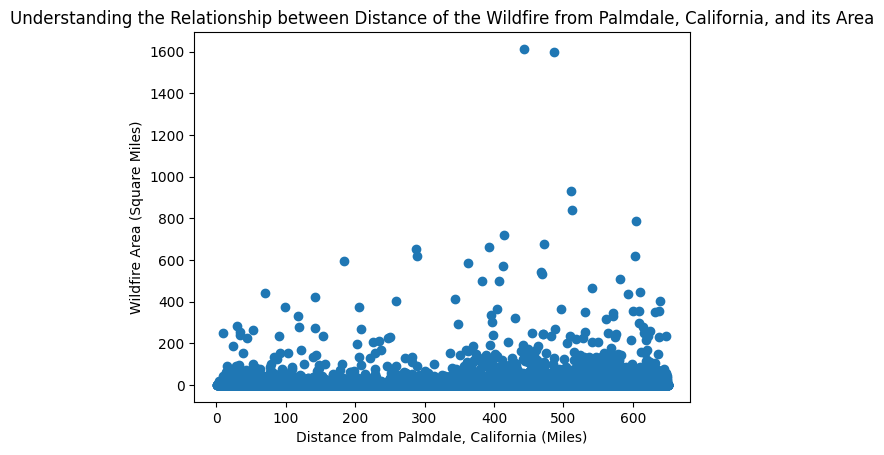

In [27]:
# Plotting 'Distance' and 'GIS_Square_Miles'
plt.scatter(wf_df['Closest_Distance_Miles'], wf_df['GIS_Square_Miles'])

# Set labels and show plot
plt.xlabel('Distance from Palmdale, California (Miles)')
plt.ylabel('Wildfire Area (Square Miles)')
plt.title('Understanding the Relationship between Distance of the Wildfire from Palmdale, California, and its Area')
plt.show()

The relationship in the above plot looks pretty random where most of the wildfires are concetrated in smaller areas region. There is no apparent relationship visible.

Let's try plotting the square of the 'Closest_Distance_Miles' with the 'GIS_Square_Miles' variable.

In [18]:
# Compute the square of the Closest_Distance_Miles and store it in a new column called 'Closest_Distance_Square_Miles'
wf_df['Closest_Distance_Square_Miles'] = (wf_df['Closest_Distance_Miles'])**2

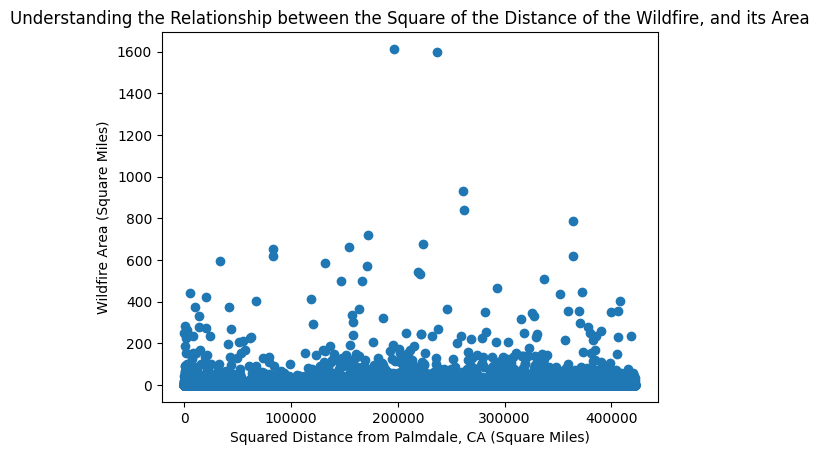

In [29]:
# Plotting 'Distance_Square' and 'GIS_Square_Miles'
plt.scatter(wf_df['Closest_Distance_Square_Miles'], wf_df['GIS_Square_Miles'])

# Set labels and show plot
plt.xlabel('Squared Distance from Palmdale, CA (Square Miles)')
plt.ylabel('Wildfire Area (Square Miles)')
plt.title('Understanding the Relationship between the Square of the Distance of the Wildfire, and its Area')
plt.show()

Since we still dont have a trend between the two variables selected we will chcek the trend between GIS_square_Miles showing how far the fire was from our city Palmdale, CA and another varibale named 'Circleness_Scale' which refers to a geometric measure of how circular or compact a fire polygon is. This type of metric can be useful in understanding the shape and spread patterns of fires. It might indicate how irregular or elongated the fire area was, which can help in studying fire behavior and its containment challenges.

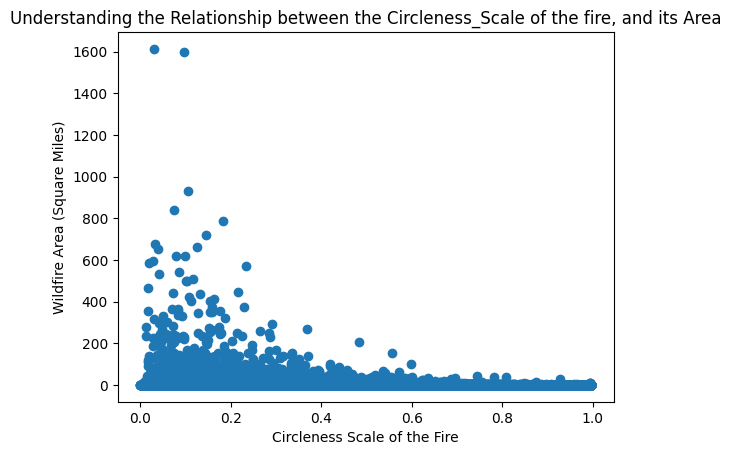

In [40]:
# Plotting 'Distance_Square' and 'GIS_Square_Miles'
plt.scatter(wf_df['Circleness_Scale'], wf_df['GIS_Square_Miles'])

# Set labels and show plot
plt.xlabel('Circleness Scale of the Fire')
plt.ylabel('Wildfire Area (Square Miles)')
plt.title('Understanding the Relationship between the Circleness_Scale of the fire, and its Area')
plt.show()

It can be observed that datapoints whose circleness_scale is smaller, tend to have a higher area. The relationship can be approximated to a decaying exponential function. 

We will also take into consideration the distance of the fire from Palmdale, CA to make an estimate of the smoke in the city since we assume that further the fire, lesser will be the smoke. But when area of the fire is more we can expect the smoke to be more as well.

Thus, the smoke estimate that best captures our intuition can be created using the following formula,

*Smoke Estimate = w1 x Area of Fire x (exp(Circleness_scale)) x (1/(w2 x Distance^2)*

where w1 and w2 are constants

The aim is to not have a very high smoke estimate value. The intention is to keep it under 50. Based on the existing data points, w1 and w2 were chosen in such a way that the overall smoke estimate value stays under 50. Thus w1 and w2 for this analysis were chosen only to keep the number of digits of 'Distance_Square' and 'Area' under control.

Since 'GIS_Square_Miles' is usually in hundreds, w1 is chosen as 1/100 to reduce the overall value of smoke estimate. Similarly, since 'Distance_Square' is a very high value usually in hundred tshousands, w2 is chosen as 1/100000 to curb the digits. Thus, the final smoke estimate looks as follows,

*Smoke Estimate = (Area of Fire x (exp(Circleness_scale)) x exp(Distance^2/100000))/100*

Using the above formula, smoke estimate is calculated for every fire in the dataset.

In [59]:
# Calculate Smoke Estimate for every fire in the dataset
#wf_df['Smoke_Estimate'] = wf_df['GIS_Square_Miles']*(np.exp(wf_df['Circleness_Scale']))*np.exp(-wf_df['Closest_Distance_Square_Miles']/100000)/100
wf_df['Smoke_Estimate'] = wf_df['GIS_Square_Miles']*np.exp(-wf_df['Closest_Distance_Square_Miles']/100000)/100


In [60]:
# Group the dataframe by the fire year and find the total number of wildfires for each year
count_by_year = wf_df.groupby(['Fire_Year'])['USGS_Assigned_ID'].count().reset_index()

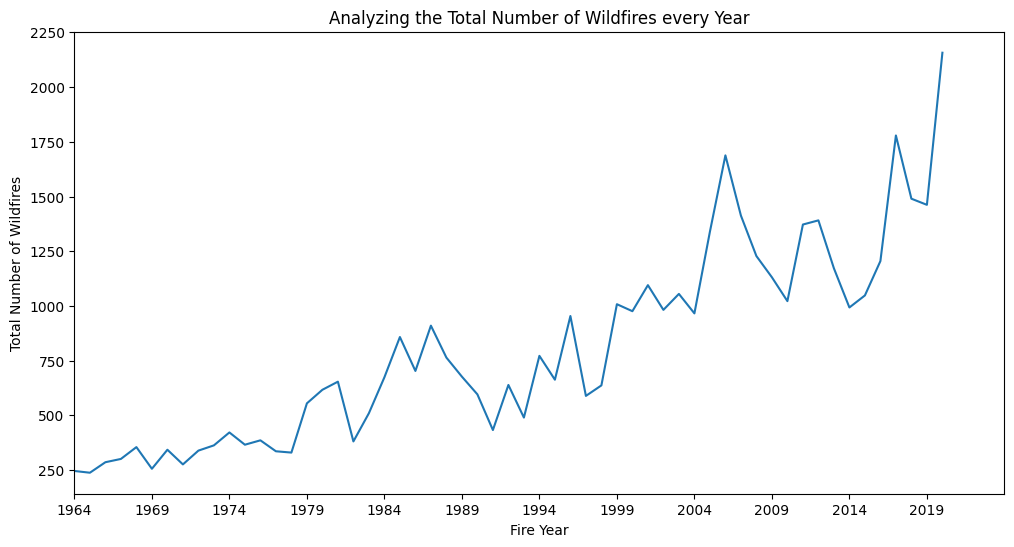

In [61]:
# Plot the total number of wildfires against the fire year
plt.figure(figsize=(12, 6))
plt.plot(count_by_year['Fire_Year'], count_by_year['USGS_Assigned_ID'])

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Total Number of Wildfires')
plt.title('Analyzing the Total Number of Wildfires every Year')
plt.xlim([1964, 2024]) 
plt.xticks(np.arange(1964, 2024, 5))
plt.show()

In [62]:
wf_df

,Unnamed: 0,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Listed_Fire_Names,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles,GIS_Square_Miles,Closest_Distance_Square_Miles,Smoke_Estimate
0,0,14600,Wildfire,1964,65338.877640,COYOTE (4),0.263753,112240.801495,2.644171e+08,78.287919,102.091996,6128.998184,0.960227
1,1,14601,Wildfire,1964,55960.694158,"C. HANLY (5), Hanley (1)",0.224592,112566.141954,2.264649e+08,367.502205,87.438585,135057.870439,0.226545
2,2,14602,Wildfire,1964,19218.105903,COZY DELL (5),0.138493,84004.974692,7.777292e+07,37.284539,30.028290,1390.136829,0.296137
3,3,14603,Wildfire,1964,18712.494750,HAYFORK HWY. #2 (5),0.391960,49273.004457,7.572678e+07,490.145821,29.238273,240242.925744,0.026460
4,4,14604,Wildfire,1964,16887.001024,"MATTOLE (5), ROBERTS COOP. ESCAPE (5)",0.392989,46746.577459,6.833927e+07,513.197125,26.385939,263371.288770,0.018948
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45886,117147,135046,Prescribed Fire,2020,20.327632,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,0.407603,1592.532526,8.226301e+04,645.322932,0.031762,416441.687068,0.000005
45887,117152,135051,Prescribed Fire,2020,16.737098,Malheur WS Alder Creek 02 (1),0.318826,1633.905090,6.773263e+04,611.460888,0.026152,373884.417676,0.000006
45888,117153,135052,Prescribed Fire,2020,60.879054,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,0.028211,10475.782440,2.463688e+05,648.440662,0.095124,420475.291774,0.000014
45889,117155,135054,Prescribed Fire,2020,10.429138,SOD 121 (1),0.511658,1018.118440,4.220522e+04,617.228369,0.016296,380970.858950,0.000004


In [63]:
# Create a new dataframe that has yearly data and the cumulative smoke estimate values
smoke_by_year = wf_df.groupby(['Fire_Year'])['Smoke_Estimate'].sum().reset_index()

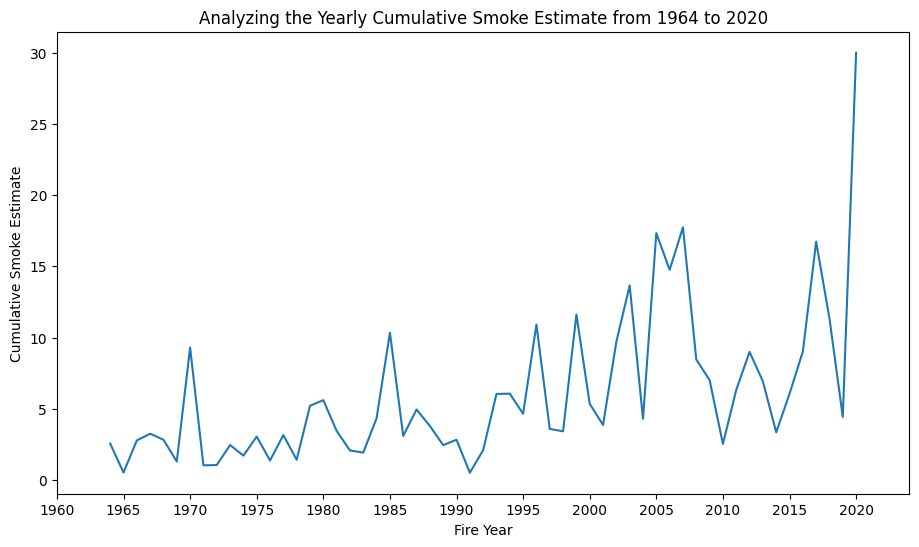

In [92]:
# Plot the cumulative smoke estimate with the fire year
plt.figure(figsize=(11, 6))
plt.plot(smoke_by_year['Fire_Year'], smoke_by_year['Smoke_Estimate'])

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate')
plt.title('Analyzing the Yearly Cumulative Smoke Estimate from 1964 to 2020')
plt.xlim([1960, 2024]) 
plt.xticks(np.arange(1960, 2024, 5))
plt.show()

In [65]:
# Read the AQI data from a CSV file to a dataframe
aqi_df = pd.read_csv('../Intermediate_Files/Yearly_AQI_Data.csv')

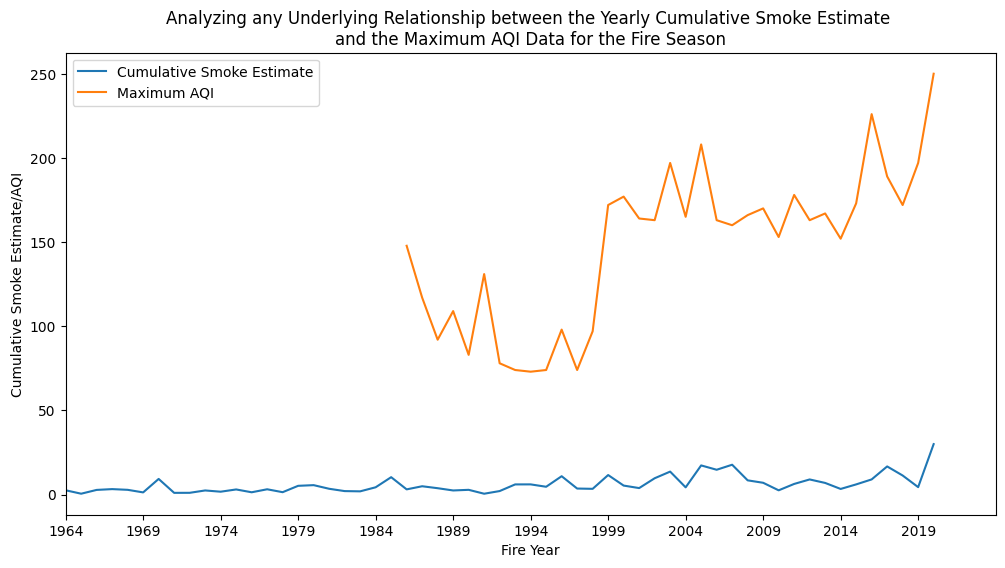

In [68]:
# Plot the cumulative smoke estimate and the maximum AQI data for every year
plt.figure(figsize=(12, 6))
plt.plot(smoke_by_year['Fire_Year'], smoke_by_year['Smoke_Estimate'], label='Cumulative Smoke Estimate')
plt.plot(aqi_df['Year'], aqi_df['AQI'], label='Maximum AQI')

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate/AQI')
plt.title('Analyzing any Underlying Relationship between the Yearly Cumulative Smoke Estimate \n\
and the Maximum AQI Data for the Fire Season')
plt.xlim([1964, 2024]) 
plt.xticks(np.arange(1964, 2024, 5))
plt.legend()
plt.show()

In [69]:
# Create a copy of the dataframe containing yearly cumulative smoke estimate data
sarimax_df = smoke_by_year.copy()

# Convert the year column to datetime and save it as a new column called 'date'
sarimax_df['date'] = pd.to_datetime(sarimax_df['Fire_Year'], errors='ignore', format='%Y')

# Set the above date column as the dataframe's index
sarimax_df = sarimax_df.set_index('date')

# Change the index to datetime object and convert into the type 'datetime64[ns]'
# It is important to convert it to the type 'datetime64[ns]' because the default type is numpy datetime
# A datetime format other than 'datetime64[ns]' throws an error while training the model
sarimax_df.index = pd.to_datetime(sarimax_df.index).astype('datetime64[ns]')

# We then drop the 'Fire_Year' column as it is no longer needed
sarimax_df.drop(['Fire_Year'], axis=1, inplace=True)

In [70]:
# Look at the top of the dataframe
sarimax_df.head()

,Smoke_Estimate
date,
1964-01-01,2.561268
1965-01-01,0.525745
1966-01-01,2.777890
1967-01-01,3.251731
1968-01-01,2.831060


In [72]:
# Fit a SARIMAX model
# Set the order and season_order parameters as per your requirements
# The fourth coordinate of the seasonal_order parameter is set to 12 for yearly data
model = sm.tsa.SARIMAX(sarimax_df['Smoke_Estimate'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Generate a list of years for our range of 1963 to 2020
years_range = np.arange(1964, 2021, 1)

# Create a datetime index with the type 'datetime64[ns]'
future_index = pd.to_datetime(years_range, format='%Y').astype('datetime64[ns]')

# Generate predictions using the start date, end date and the time-series index
forecast = results.get_prediction(start=future_index[0], end=future_index[-1], exog=sarimax_df.index)

# Extract the predicted mean values for the years 1963 to 2020
Y_pred = list(forecast.predicted_mean)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86147D+00    |proj g|=  6.08937D-01

At iterate    5    f=  2.45067D+00    |proj g|=  3.04879D-02

At iterate   10    f=  2.41816D+00    |proj g|=  1.09358D-02

At iterate   15    f=  2.41720D+00    |proj g|=  2.88271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   1.109D-06   2.417D+00
  F =   2.4171951449101683     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


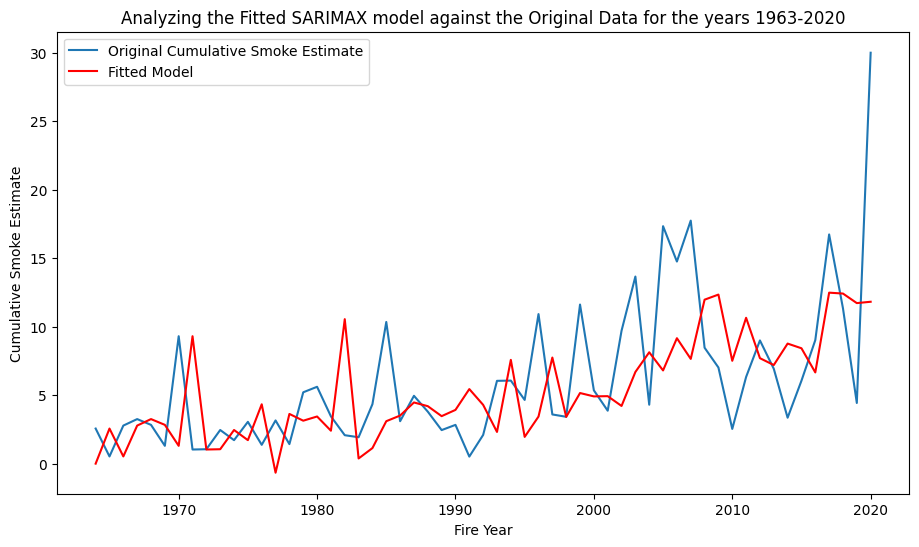

In [73]:
# Plot the original data with the fitted model
X = list(smoke_by_year['Fire_Year'])
Y = list(smoke_by_year['Smoke_Estimate'])

plt.figure(figsize=(11, 6))
plt.plot(X, Y, label='Original Cumulative Smoke Estimate')

# Plot the fitted model line
plt.plot(X, Y_pred, 'r-', label='Fitted Model')

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate')
plt.title('Analyzing the Fitted SARIMAX model against the Original Data for the years 1963-2020')
plt.legend()
plt.show()

In [74]:
# Generate a list of years for our range of 2021 to 2050
years_range = np.arange(2021, 2051, 1)

# Create a datetime index with the type 'datetime64[ns]'
future_index = pd.to_datetime(years_range, format='%Y').astype('datetime64[ns]')

# Generate predictions using the start date, end date and the time-series index
forecast = results.get_prediction(start=future_index[0], end=future_index[-1], exog=sarimax_df.index)

# Extract the predicted mean values for the years 2021 to 2049 and their confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

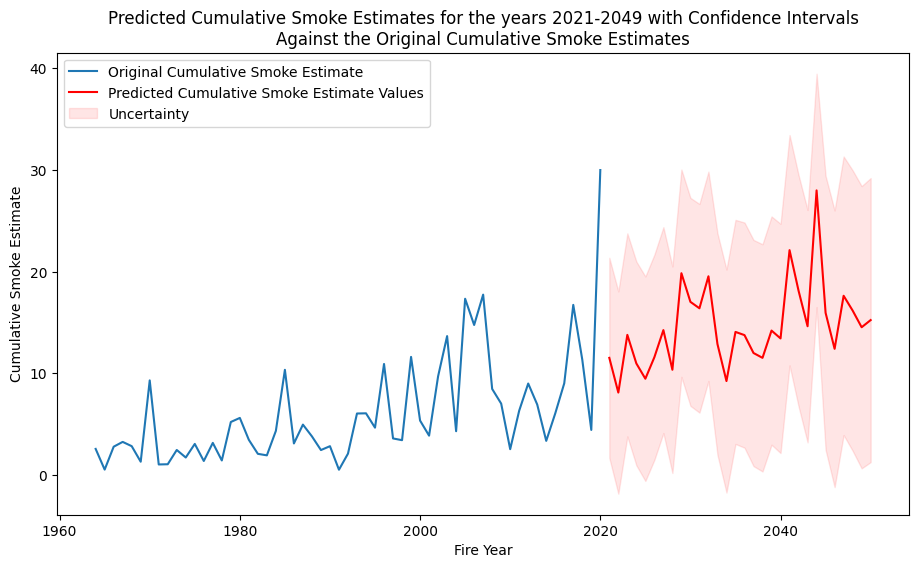

In [75]:
# Plot the actual data
plt.figure(figsize=(11, 6))
plt.plot(X, Y, label='Original Cumulative Smoke Estimate')

# Plot the predicted values
plt.plot(years_range, forecast_values, color='red', label='Predicted Cumulative Smoke Estimate Values')

# Plot the confidence intervals
plt.fill_between(
    years_range,
    list(confidence_intervals.iloc[:, 0]),
    list(confidence_intervals.iloc[:, 1]),
    color='red', alpha=0.1, label='Uncertainty'
)

# Set labels and show plot
plt.legend(loc='upper left')
plt.title('Predicted Cumulative Smoke Estimates for the years 2021-2049 with Confidence Intervals\n\
Against the Original Cumulative Smoke Estimates')
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate')
plt.show()

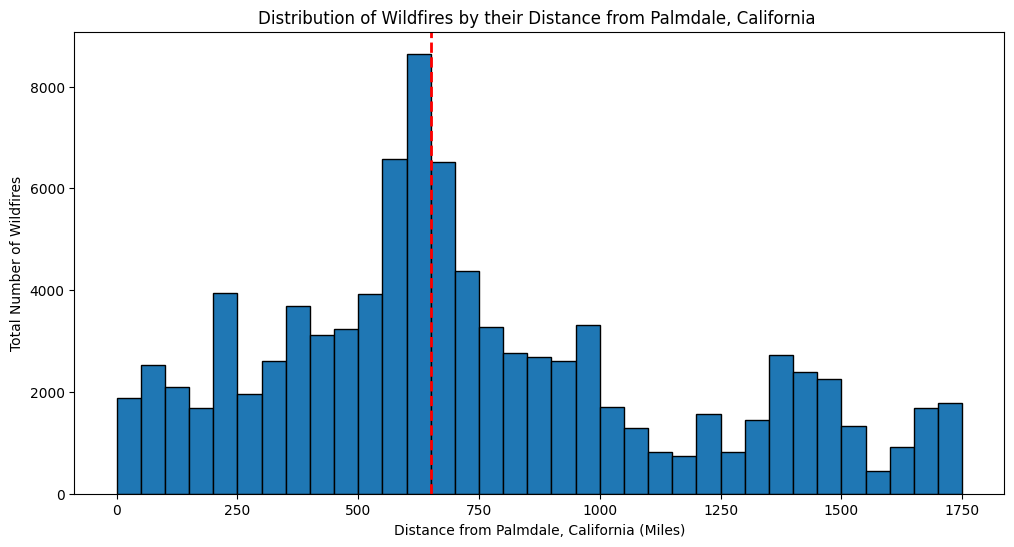

In [89]:
# Plot the distribution of wildfires by their distance from Palmdale, California
plt.figure(figsize=(12, 6))
bins = np.arange(0, 1800, 50)
plt.hist(wf_df_all['Closest_Distance_Miles'], bins=bins, edgecolor='black')

# Add a red dashed vertical line at 650 miles
plt.axvline(x=650, color='red', linestyle='--', linewidth=2, label='650 Miles Cut-off')

# Set labels and show plot
plt.xlabel('Distance from Palmdale, California (Miles)')
plt.ylabel('Total Number of Wildfires')
plt.title('Distribution of Wildfires by their Distance from Palmdale, California ')
plt.show()

In [80]:
# Group the data by year and calculate the total burnt acres
acres_by_year = wf_df.groupby(['Fire_Year'])['GIS_Acres'].sum().reset_index()

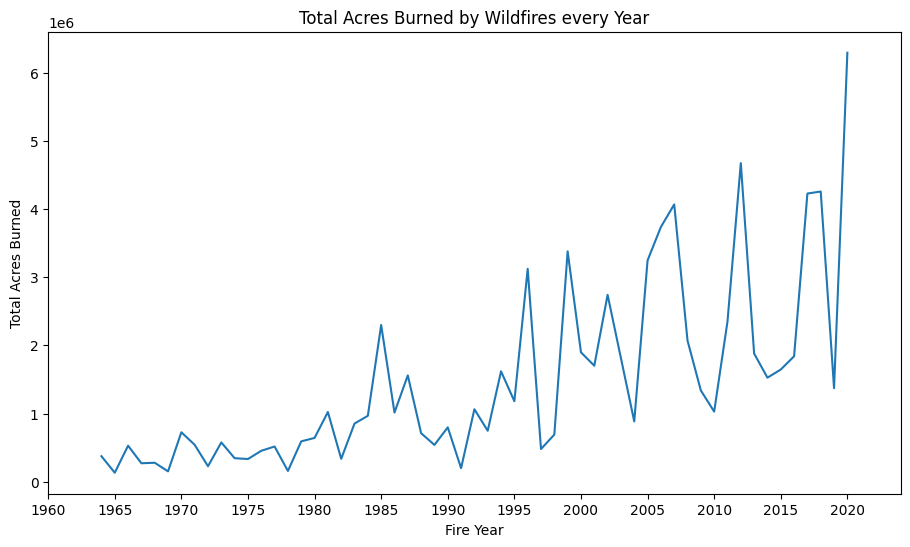

In [90]:
# Plot the total acres burnt every year
plt.figure(figsize=(11, 6))
plt.plot(acres_by_year['Fire_Year'], acres_by_year['GIS_Acres'])

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned by Wildfires every Year')
plt.xlim([1960, 2024]) 
plt.xticks(np.arange(1960, 2024, 5))
plt.show()

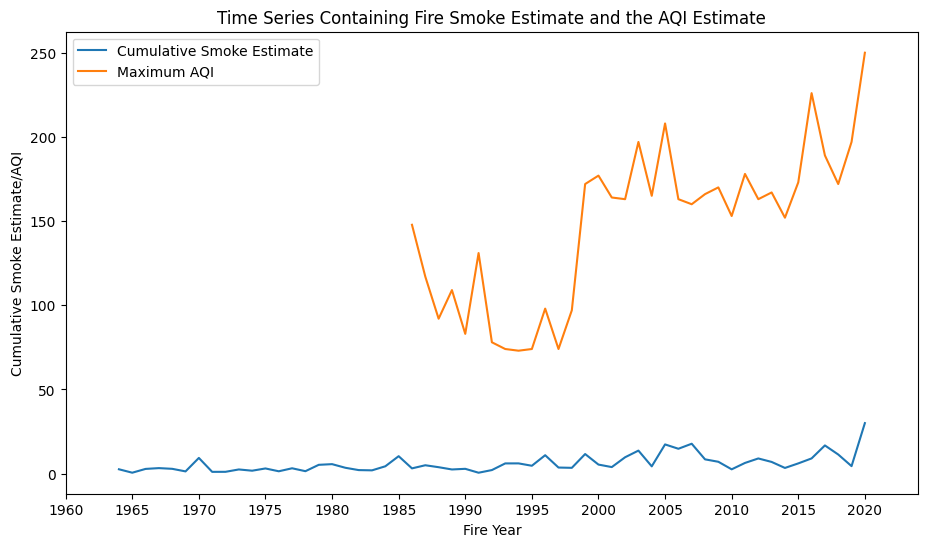

In [84]:
# Plot the cumulative smoke estimate and the maximum AQI data for every year
plt.figure(figsize=(11, 6))
plt.plot(smoke_by_year['Fire_Year'], smoke_by_year['Smoke_Estimate'], label='Cumulative Smoke Estimate')
plt.plot(aqi_df['Year'], aqi_df['AQI'], label='Maximum AQI')

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate/AQI')
plt.title('Time Series Containing Fire Smoke Estimate and the AQI Estimate')
plt.xlim([1960, 2024]) 
plt.xticks(np.arange(1960, 2024, 5))
plt.legend()
plt.show()